## Transfer_learning with Tensorflow Part 2 Fine Tunning

In [1]:
# Check if we are using GPU
!nvidia-smi

Thu Jan  5 13:13:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions
In previous notebooks we have created a bunch of helper functions in previous notebooks

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-05 13:13:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-05 13:13:08 (98.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we are oin to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves,unzip_data, walk_through_dir

We have imported these helper functions from mrdbourke github

## Lets get data ready 

We will import the models using tf.keras.applications and apply them to our own problem recognizing images of food 

In [4]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2023-01-05 13:13:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  40.3MB/s    in 4.6s    

2023-01-05 13:13:16 (35.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check out how many images and subdirectories are there 
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/trai

In [6]:
# Create training and test directories path
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [7]:
import tensorflow as tf
IMG_SIZE =(224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = "categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical",
                                                                batch_size = BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Check out class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See example of batch data
for images,labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[2.70714283e+01 2.40714283e+01 1.50714283e+01]
   [2.50714283e+01 2.20714283e+01 1.30714283e+01]
   [2.46428566e+01 2.16428566e+01 1.26428576e+01]
   ...
   [7.77092133e+01 6.49184036e+01 4.07091675e+01]
   [9.05969849e+01 7.52398376e+01 5.15255547e+01]
   [9.33571091e+01 7.79999619e+01 5.42856789e+01]]

  [[2.46683674e+01 2.16683674e+01 1.26683674e+01]
   [2.59948978e+01 2.29948978e+01 1.39948978e+01]
   [2.48571415e+01 2.18571415e+01 1.28571424e+01]
   ...
   [4.68571396e+01 3.95714264e+01 2.14285698e+01]
   [5.01479683e+01 4.27295799e+01 2.46530609e+01]
   [5.04999237e+01 4.12142105e+01 2.40713558e+01]]

  [[2.60000000e+01 2.30000000e+01 1.40000000e+01]
   [2.48571434e+01 2.18571434e+01 1.28571424e+01]
   [2.28316326e+01 1.98316326e+01 1.08316326e+01]
   ...
   [4.09540634e+01 3.69540634e+01 2.51683502e+01]
   [4.11581650e+01 3.55867386e+01 2.38010235e+01]
   [4.14336815e+01 3.58622513e+01 2.40765381e+01]]

  ...

  [[1.88602325e+02 1.86602325e+02 1.64030853e+02]
   [1

## Model 0 : Building a transfer learning model using the keras functional api

The functional api gives us more flexibility with oour models

In [11]:
#  1. Creating base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3 Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3),name = "input_layer")

# 4. If using ResNet50V2 you will need to normalize inputs
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5.  Pass the inputs to the base models
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information,reduse number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# Create output activation layer
outputs = tf.keras.layers.Dense(10,activation="softmax",name="output_layers")(x)

# 8 combine the inputs with outputs into the model
model_0 = tf.keras.Model(inputs,outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data)), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",experiment_name= "10_percent_feature_extract")])
     

16705208/16705208 [==============================] - 1s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20230105-131325
Epoch 1/5
24/24 [==============================] - 19s 232ms/step - loss: 1.8888 - accuracy: 0.4240 - val_loss: 1.3040 - val_accuracy: 0.7664
Epoch 2/5
24/24 [==============================] - 5s 186ms/step - loss: 1.0963 - accuracy: 0.7680 - val_loss: 0.8747 - val_accuracy: 0.8158
Epoch 3/5
24/24 [==============================] - 4s 159ms/step - loss: 0.7998 - accuracy: 0.8267 - val_loss: 0.6880 - val_accuracy: 0.8454
Epoch 4/5
24/24 [==============================] - 4s 154ms/step - loss: 0.6463 - accuracy: 0.8573 - val_loss: 0.6242 - val_accuracy: 0.8339
Epoch 5/5
24/24 [==============================] - 9s 355ms/step - loss: 0.5517 - accuracy: 0.8827 - val_loss: 0.5543 - val_accuracy: 0.8618


In [12]:
# Evaluate on th full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 9s 104ms/step - loss: 0.5572 - accuracy: 0.8636


[0.5572492480278015, 0.8636000156402588]

In [13]:
# Check the layers in our base model
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 tf.math.truediv
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [14]:
# How about we get the summary of our base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   7           ['rescaling[0][0]']              
                                3)                                                   

In [15]:
# How about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layers (Dense)       (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


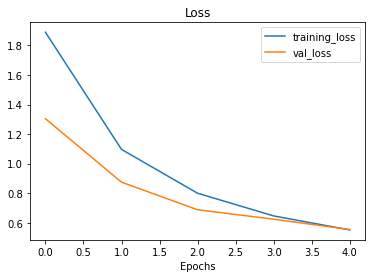

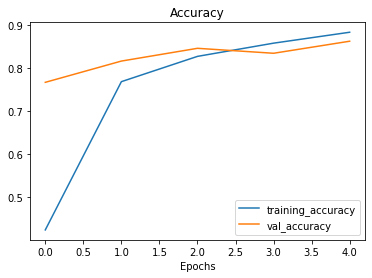

In [16]:
# Check out our models training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

lets demonstrate Global Average pooling layer 2D

We have a tensor after our model goes through base_model of shape (None,7,7,1280) .

But then when it passes through GlobalAveragePooling2D it turns into (None,1280).

Lets use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D

In [17]:
# Define the input shape
input_shape = (1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n{input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n{global_average_pooled_tensor}\n")

Random input tensor:
[[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
[[-0.09368646 -0.45840448 -0.2885598 ]]



## Running a series of transfer learning experiments

We have seen the incredible results transferlearning can get with 10 percent of data lets see what we get with 1 percent of data

1. model_1: Use feature extraction transfer learning on 1% of the training data with data augmentation.
2. model_2: Use feature extraction transfer learning on 10% of the training data with data augmentation.
3. model_3: Use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. model_4: Use fine-tuning transfer learning on 100% of the training data with data augmentation.

In [18]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2023-01-05 13:14:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 142.250.145.128, 2a00:1450:4013:c01::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  35.5MB/s    in 4.2s    

2023-01-05 13:14:25 (30.6 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [19]:
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"

In [20]:
# How many images are we working with
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There a

In [21]:
# Set up data loaders
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size =BATCH_SIZE)# defaul =32
test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(test_dir_1_percent,
                                                                           label_mode = "categorical",
                                                                           image_size = IMG_SIZE,
                                                                           batch_size =BATCH_SIZE)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into model
 We can add augmentation in model layer

In [22]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping rotation , zooms etc

data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet have it builtin
],name = "data_augmentation")


### Visulaize our data augmentation layer (and see what happens to our data)


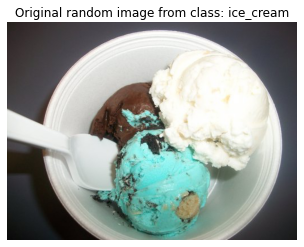

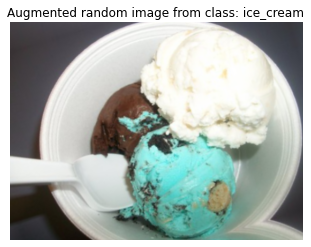

In [23]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0),training=True) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Model_1 Feature extraction transfer learning on 1 percent of data

In [24]:
# Setup the input shape and base model freezing  the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
# Creating input layer
inputs = layers.Input(shape = input_shape, name ="input_layer")

# Add in data augmentation Sequential model as layer
x = data_augmentation(inputs)

# Give base model inputs (after augmentation) and dont train it 
x = base_model(x,training=False)

# Pool the outputfeatures of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer on as output
outputs = layers.Dense(10,activation="softmax",name="output_layer")(x)

# Make a model using inputs and outputs
model_1 = tf.keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data_1_percent,
                    validation_steps=int(0.25* len(test_data_1_percent)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230105-131431
Epoch 1/5
3/3 [==============================] - 16s 4s/step - loss: 2.4157 - accuracy: 0.1000 - val_loss: 2.2193 - val_accuracy: 0.2138
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1401 - accuracy: 0.2429 - val_loss: 2.0714 - val_accuracy: 0.2993
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9470 - accuracy: 0.4143 - val_loss: 1.9752 - val_accuracy: 0.3635
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.7455 - accuracy: 0.5714 - val_loss: 1.8660 - val_accuracy: 0.4391
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6281 - accuracy: 0.6000 - val_loss: 1.7741 - val_accuracy: 0.5230


In [25]:
# Check out our model summary()
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [26]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 75ms/step - loss: 1.7908 - accuracy: 0.4928


[1.7907828092575073, 0.4927999973297119]

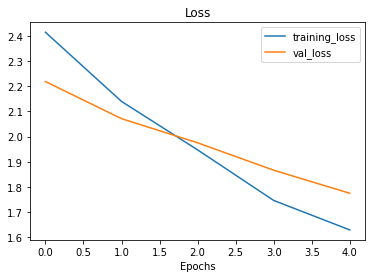

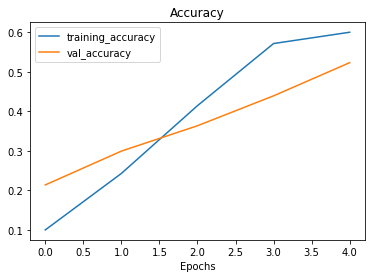

In [27]:
# How do the model with one percent of the data and loss curve look
plot_loss_curves(history_1_percent)

# Model2: feature extraction transfer learning model with 10% of data and data augmentation

In [28]:
# Get 10 percent of data
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
#unzip_data(10_food_classes_10_percent)
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [29]:
# Set data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode = "categorical",
                                                                            image_size = IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [30]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/trai

In [31]:
import tensorflow as tf

In [32]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping rotation , zooms etc

data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet have it builtin
],name = "data_augmentation")


### Creating a model Checkpoint call back

In [33]:
# Set check point path 
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# Create a modelcheckpoint
model_check_points = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only = False,
                                                 save_freq = "epoch",
                                                 verbose = 1)

In [34]:
# Setup the input shape and base model freezing  the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False
# Creating input layer
inputs = layers.Input(shape = input_shape, name ="input_layer")

# Add in data augmentation Sequential model as layer
x = data_augmentation(inputs)

# Give base model inputs (after augmentation) and dont train it 
x = base_model(x,training=False)

# Pool the outputfeatures of the base model
x = layers.GlobalAveragePooling2D()(x)

# Put a dense layer on as output
outputs = layers.Dense(10,activation="softmax",name="output_layer")(x)

# Make a model using inputs and outputs
model_2 = tf.keras.Model(inputs,outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_10_percent = model_2.fit(train_data_10_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_10_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback(dir_name="transfer_learning", experiment_name="10_percent_data_aug"),
                               model_check_points])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230105-131520
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9766 - accuracy: 0.3680
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 18s 515ms/step - loss: 1.9766 - accuracy: 0.3680 - val_loss: 1.4586 - val_accuracy: 0.6793
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3050 - accuracy: 0.6853
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 412ms/step - loss: 1.3050 - accuracy: 0.6853 - val_loss: 0.9768 - val_accuracy: 0.8026
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9766 - accuracy: 0.7733
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 10s 397ms/step - loss: 0.9766 - accuracy: 0.7733 - val_loss: 0.8010 - val_accuracy: 0.8059
E

In [35]:
# What were model 0 result
model_0.evaluate(test_data)

79/79 [==============================] - 7s 74ms/step - loss: 0.5572 - accuracy: 0.8636


[0.5572494268417358, 0.8636000156402588]

In [36]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 74ms/step - loss: 0.6191 - accuracy: 0.8404


[0.619129478931427, 0.840399980545044]

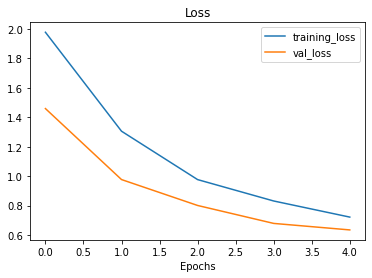

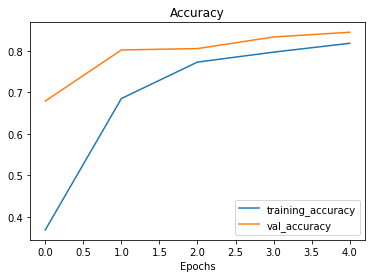

In [37]:
# Plot model loss cure
plot_loss_curves(history_10_percent)

### Loading in checkpointed weights returs a model to a specific checkpoint

In [38]:
# Load in saved model weights and evaluate
model_2.load_weights(checkpoint_path)

In [39]:
#Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.6191 - accuracy: 0.8404


In [40]:
# If the result from our previously evaluated model_2 match the loaded weights every thing has gone well
results_10_percent_data_aug == loaded_weights_model_results

False

In [41]:
# Check to see if loaded model results are very close to our loaded model results
import numpy as np 
np.isclose(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_results))

array([ True,  True])

In [42]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug)-np.array(loaded_weights_model_results))

[5.96046448e-08 0.00000000e+00]


## Model 3: Fine tunning  an existing model on 10 percent of data
it usually works well after pretraining a model for some epochs

In [43]:
# Layers in loaded model
model_2.layers

In [44]:
# Are these layers trainable
for layer in model_2.layers:
  print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fe287de3d60> True
<keras.engine.sequential.Sequential object at 0x7fe287f1aca0> True
<keras.engine.functional.Functional object at 0x7fe287ca3e20> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7fe287f35760> True
<keras.layers.core.dense.Dense object at 0x7fe2866e7f40> True


In [45]:
for i,layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [46]:
# How many trainable variable are there in our base model
print(len(model_2.layers[2].trainable_variables))

0


In [47]:
# To begin fine tuning lets start by setting last 10 layer of our model trainable
base_model.trainable = True

# Freze all laers except the last 10
for layers in base_model.layers[:-10]:
  layers.trainable = False
# Recompile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(lr =0.0001),
                metrics = ["accuracy"])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [48]:
# Check which layers are tunable(trainable)
for layer_number, layers in enumerate(model_2.layers[2].layers):
  print(layer_number,layers.name,layers.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 tf.math.truediv_2 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [49]:
# Fine tune for another 5 epochs
initial_epochs = 5
fine_tune_epochs = initial_epochs +5

# Refit the model
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data = test_data,
                                               validation_steps =int(0.25*len(test_data)),
                                               initial_epoch = history_10_percent.epoch[-1],
                                               callbacks = [create_tensorboard_callback(dir_name="transfer_learning",
                                                                                        experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230105-131657
Epoch 5/10
24/24 [==============================] - 20s 522ms/step - loss: 0.6467 - accuracy: 0.8147 - val_loss: 0.5043 - val_accuracy: 0.8487
Epoch 6/10
24/24 [==============================] - 10s 389ms/step - loss: 0.4912 - accuracy: 0.8533 - val_loss: 0.4599 - val_accuracy: 0.8569
Epoch 7/10
24/24 [==============================] - 10s 402ms/step - loss: 0.4282 - accuracy: 0.8747 - val_loss: 0.4559 - val_accuracy: 0.8503
Epoch 8/10
24/24 [==============================] - 9s 357ms/step - loss: 0.3920 - accuracy: 0.8800 - val_loss: 0.3955 - val_accuracy: 0.8766
Epoch 9/10
24/24 [==============================] - 8s 302ms/step - loss: 0.3585 - accuracy: 0.8947 - val_loss: 0.3934 - val_accuracy: 0.8750
Epoch 10/10
24/24 [==============================] - 8s 342ms/step - loss: 0.3004 - accuracy: 0.9213 - val_loss: 0.4034 - val_accuracy: 0.8635


In [50]:
# Evaluate the fine _tuned model
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 75ms/step - loss: 0.4259 - accuracy: 0.8552


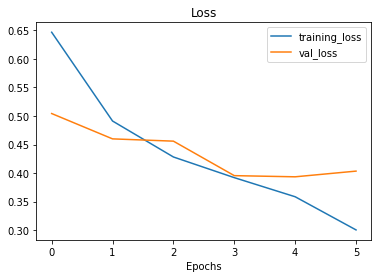

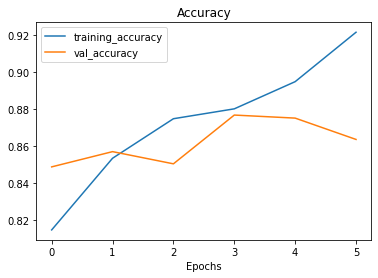

In [51]:
# Check out the loss curve of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

In [60]:
# Lets create a function to compare histories
def compare_historys(orignal_history,new_history,initial_epochs):
  """
  comapre to tensorflow history objects
  """
  # Get Orignal history measurements
  acc = orignal_history.history["accuracy"]
  loss = orignal_history.history["loss"]

  val_acc = orignal_history.history["val_accuracy"]
  val_loss = orignal_history.history["val_loss"]

  # Combine orignal history
  total_acc = acc +new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = acc +new_history.history["val_accuracy"]
  total_val_loss = loss + new_history.history["val_loss"]

  # Make plots for accuracy
  plt.figure(figsize = (8,8))
  plt.subplot(2,1,1)
  plt.plot(total_acc,label = "Training Accuracy")
  plt.plot(total_val_acc , label="val_Accuracy")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")
  
  # Make plots for loss
  plt.figure(figsize = (8,8))
  plt.subplot(2,1,1)
  plt.plot(total_loss,label = "Training Loss")
  plt.plot(total_val_loss , label="val_loss")
  plt.plot([initial_epochs-1,initial_epochs-1],plt.ylim(),label="Start Fine Tuning")
  plt.legend(loc=" upper right")
  plt.title("Training and Validation Loss")


<ipython-input-60-b1c21ab37fcd>:35: MatplotlibDeprecationWarning: Unrecognized location ' upper right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc=" upper right")


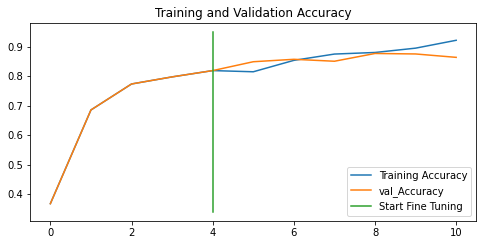

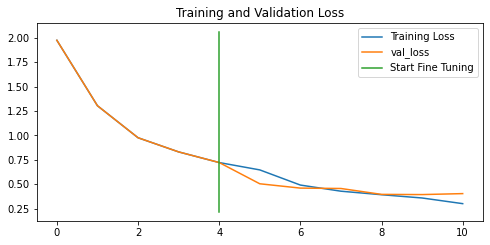

In [61]:
compare_historys(history_10_percent,
                 history_fine_10_percent_data_aug,
                 initial_epochs=5)

## Model 4 : fine tuning a trained model on 100 percent of data

In [62]:
# Download and unzip 10 classes of food 101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

unzip_data("10_food_classes_all_data.zip")

--2023-01-05 13:47:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 142.250.153.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  40.1MB/s    in 13s     

2023-01-05 13:47:22 (37.9 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [63]:
# Setup training and test dir
train_dir = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [64]:
# How many images are we working with
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.

In [65]:
# Setup data inputs
import tensorflow as tf
train_data_all = tf.keras.preprocessing.image_dataset_from_directory("10_food_classes_all_data/train")
test_data = tf.keras.preprocessing.image_dataset_from_directory("10_food_classes_all_data/test")

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
